## [DO NOT EDIT] Header

本笔记本实现了用于数字分类的决策树模型，包含超参数调优。
所有代码必须遵循实现指南中定义的项目结构和命名约定。

In [1]:
# Import required libraries
import sys
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# 魔法命令
%matplotlib inline

# 路径设置 - 导入此模块会自动设置Python路径
import path_setup

# 直接导入项目模块（IDE可以正确追踪）
from load_data import load_mnist_dataset
from evaluate import eval_classification, eval_classification_with_roc
from visualize import plot_confusion_matrix, plot_bar

# Constants
RANDOM_STATE = 42
NOTEBOOK_BASENAME = "part4_decision_tree"

# Ensure output directories exist
os.makedirs("../results/figures", exist_ok=True)
os.makedirs("../results/metrics", exist_ok=True)

print("✓ 环境设置完成")


✓ 环境设置完成


## Dataset Loading

使用提供的API函数加载数字数据集。

In [2]:
# Load the digits dataset
X_train, X_test, y_train, y_test, target_names = load_mnist_dataset()
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of classes: {len(target_names)}")

正在加载 MNIST 数据集...
训练集图像形状: (60000, 28, 28)
训练集标签形状: (60000,)
测试集图像形状: (10000, 28, 28)
测试集标签形状: (10000,)
MNIST 数据集加载完成！
Training set shape: (60000, 784)
Test set shape: (10000, 784)
Number of classes: 10


## Model Definition (Default Only)

仅定义一个模型实例，使用库默认参数。

In [3]:
# Define default model with library defaults
from sklearn.tree import DecisionTreeClassifier
default_model = DecisionTreeClassifier(
    random_state=RANDOM_STATE
)

## Training (Default Model)

对默认参数模型执行训练，记录训练用时。

In [4]:
# Train the default model
start_time = time.time()
default_model.fit(X_train, y_train)
default_training_time = time.time() - start_time
print(f"Default model training time: {default_training_time:.4f} seconds")

Default model training time: 32.3387 seconds


## Evaluation (Default Model)

评估默认模型性能。

In [5]:
# Evaluate the default model
default_metrics = eval_classification(default_model, X_test, y_test, target_names)

# Enhanced evaluation with ROC-AUC for default model
enhanced_metrics = eval_classification_with_roc(
    default_model, X_test, y_test, target_names, print_report=True
)

# 显示 ROC-AUC 分数
if 'roc_auc_macro_ovr' in enhanced_metrics:
    print(f"ROC-AUC (Macro OvR): {enhanced_metrics['roc_auc_macro_ovr']:.4f}")

== Evaluation Metrics ==
accuracy                 : 0.8755
precision_macro          : 0.8741
recall_macro             : 0.8739
f1_macro                 : 0.8740
weighted_f1              : 0.8754
roc_auc_macro_ovr        : 0.9300
== Classification Report ==
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       980
           1       0.95      0.96      0.95      1135
           2       0.86      0.86      0.86      1032
           3       0.83      0.85      0.84      1010
           4       0.86      0.87      0.87       982
           5       0.85      0.83      0.84       892
           6       0.90      0.88      0.89       958
           7       0.91      0.90      0.91      1028
           8       0.82      0.81      0.81       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.88      

## Visualization (Default Model)

可视化默认模型结果。

Default model confusion matrix saved to ../results/figures/part4_decision_tree__cm_default.png


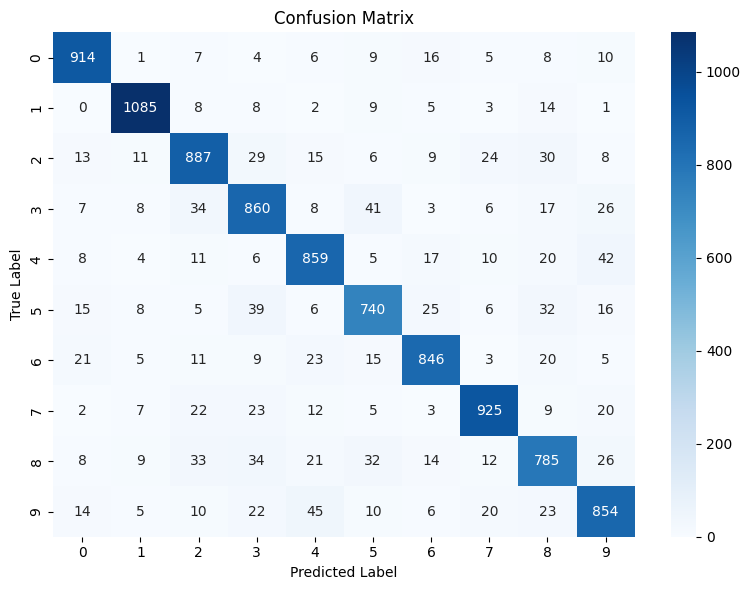

In [6]:
# Plot confusion matrix for default model
out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__cm_default.png"
plot_confusion_matrix(default_metrics['confusion_matrix'], target_names, out_png_path)
print(f"Default model confusion matrix saved to {out_png_path}")

## Fill Hyperparams (Tuning Spec)

定义调参网格。

In [8]:
# Define hyperparameter grid for Decision Tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define base model with stability parameters
base_model = DecisionTreeClassifier(
    random_state=RANDOM_STATE
)

# Define parameter grid (strictly follow Canvas Chapter 4)
param_grid = {
    'max_depth': [5, 7, None],
    'min_samples_split': [2, 5]
}

# Create GridSearchCV object
gs = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Execute grid search
gs.fit(X_train, y_train)

# Print best parameters and CV score
print("Best params:", gs.best_params_)
print("Best CV score (accuracy):", gs.best_score_)

# Get best model and evaluate on test set
best_model = gs.best_estimator_
test_acc = best_model.score(X_test, y_test)
print("Test accuracy with best params:", test_acc)

# Save variables for later use
model = best_model
best_params = gs.best_params_
best_training_time = gs.cv_results_['mean_fit_time'][gs.best_index_]

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'max_depth': None, 'min_samples_split': 2}
Best CV score (accuracy): 0.8664
Test accuracy with best params: 0.8755


## Training (Tuned Model)

使用最佳参数实例化第二个模型对象并训练，记录用时。

In [9]:
# Train the best model (already done during grid search)
print(f"Best model trained with hyperparameters: {best_params}")
print(f"Training time: {best_training_time:.4f} seconds")

Best model trained with hyperparameters: {'max_depth': None, 'min_samples_split': 2}
Training time: 50.7064 seconds


## Evaluation (Tuned Model)

评估调参后模型性能。

In [10]:
# Evaluate the best model
final_metrics = eval_classification(best_model, X_test, y_test, target_names)

# Enhanced evaluation with ROC-AUC for best model
enhanced_metrics = eval_classification_with_roc(
    best_model, X_test, y_test, target_names, print_report=True
)

# 显示 ROC-AUC 分数
if 'roc_auc_macro_ovr' in enhanced_metrics:
    print(f"ROC-AUC (Macro OvR): {enhanced_metrics['roc_auc_macro_ovr']:.4f}")

== Evaluation Metrics ==
accuracy                 : 0.8755
precision_macro          : 0.8741
recall_macro             : 0.8739
f1_macro                 : 0.8740
weighted_f1              : 0.8754
roc_auc_macro_ovr        : 0.9300
== Classification Report ==
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       980
           1       0.95      0.96      0.95      1135
           2       0.86      0.86      0.86      1032
           3       0.83      0.85      0.84      1010
           4       0.86      0.87      0.87       982
           5       0.85      0.83      0.84       892
           6       0.90      0.88      0.89       958
           7       0.91      0.90      0.91      1028
           8       0.82      0.81      0.81       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.88      

## Visualization (Tuned Model + Param Curves)

可视化调参后模型结果和性能曲线。

Tuned model confusion matrix saved to ../results/figures/part4_decision_tree__cm_tuned.png


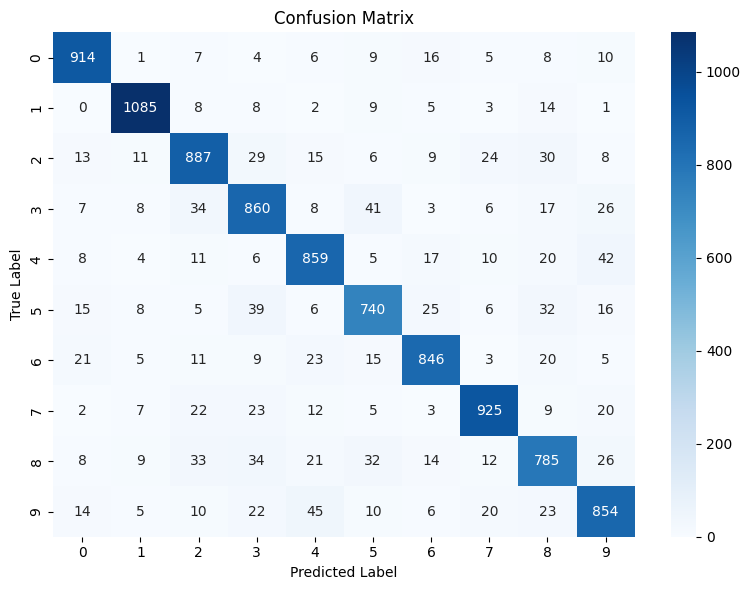

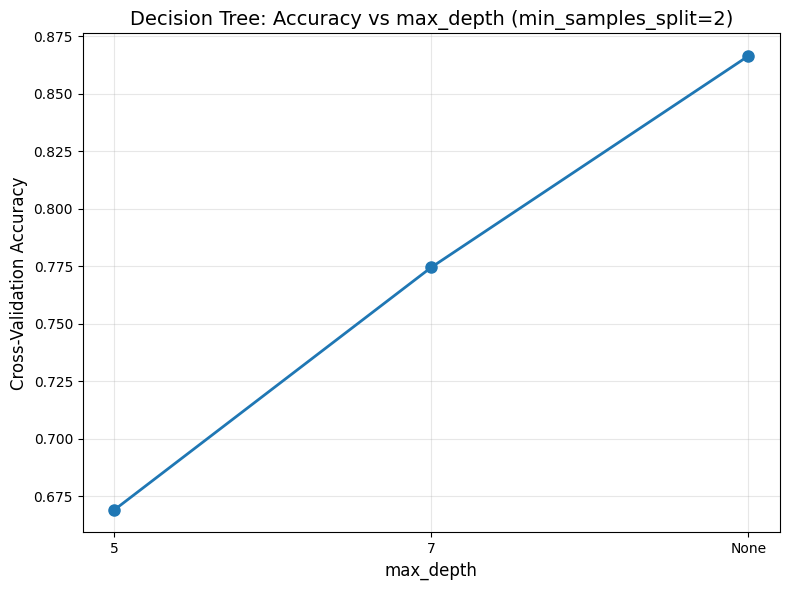

Accuracy vs max_depth plot saved to ../results/figures/part4_decision_tree__acc_vs_max_depth.png


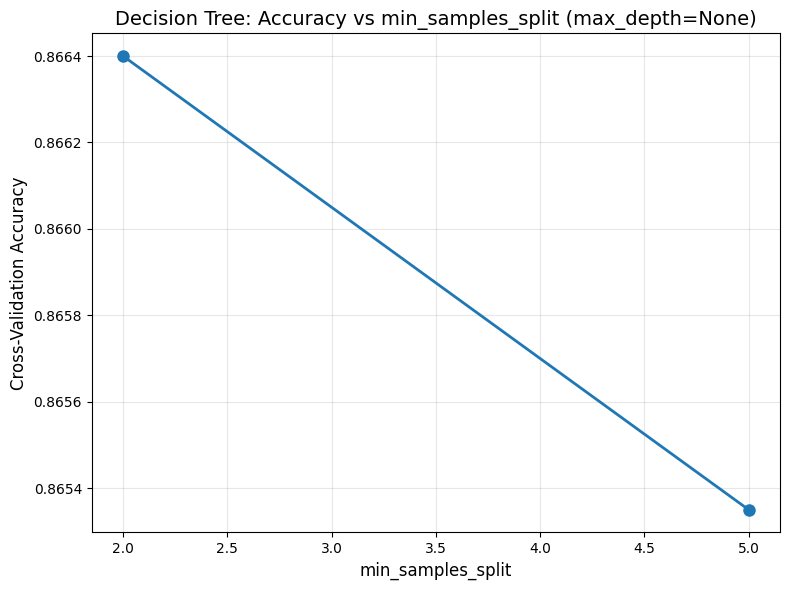

Accuracy vs min_samples_split plot saved to ../results/figures/part4_decision_tree__acc_vs_min_samples_split.png


In [11]:
# ① Plot confusion matrix for tuned model
cm = final_metrics['confusion_matrix']
out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__cm_tuned.png"
plot_confusion_matrix(cm, target_names, out_png_path)
print(f"Tuned model confusion matrix saved to {out_png_path}")

# ② Plot parameter performance curves
cv_results = gs.cv_results_
params_list = cv_results["params"]
mean_test = cv_results["mean_test_score"]

# Plot each parameter
for param_key in param_grid.keys():
    if param_key == 'max_depth':
        # Use best min_samples_split
        best_mss = best_params['min_samples_split']
        depth_vals = []
        scores = []
        for i, params in enumerate(params_list):
            if params['min_samples_split'] == best_mss:
                depth_vals.append(params['max_depth'])
                scores.append(mean_test[i])
        
        # Sort, handling None
        def sort_key(x):
            return (999 if x[0] is None else x[0])
        sorted_pairs = sorted(zip(depth_vals, scores), key=sort_key)
        depth_vals_sorted = [p[0] for p in sorted_pairs]
        scores_sorted = [p[1] for p in sorted_pairs]
        
        # Convert None to string for plotting
        depth_labels = [str(d) if d is not None else 'None' for d in depth_vals_sorted]
        x_positions = range(len(depth_labels))
        
        # Plot
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(x_positions, scores_sorted, marker='o', linewidth=2, markersize=8)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(depth_labels)
        ax.set_xlabel('max_depth', fontsize=12)
        ax.set_ylabel('Cross-Validation Accuracy', fontsize=12)
        ax.set_title(f'Decision Tree: Accuracy vs max_depth (min_samples_split={best_mss})', fontsize=14)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__acc_vs_max_depth.png"
        plt.savefig(out_png_path, dpi=100, bbox_inches='tight')
        plt.show()
        print(f"Accuracy vs max_depth plot saved to {out_png_path}")
    
    elif param_key == 'min_samples_split':
        # Use best max_depth
        best_depth = best_params['max_depth']
        mss_vals = []
        scores = []
        for i, params in enumerate(params_list):
            if params['max_depth'] == best_depth:
                mss_vals.append(params['min_samples_split'])
                scores.append(mean_test[i])
        
        # Sort
        sorted_pairs = sorted(zip(mss_vals, scores))
        mss_vals_sorted = [p[0] for p in sorted_pairs]
        scores_sorted = [p[1] for p in sorted_pairs]
        
        # Plot
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(mss_vals_sorted, scores_sorted, marker='o', linewidth=2, markersize=8)
        ax.set_xlabel('min_samples_split', fontsize=12)
        ax.set_ylabel('Cross-Validation Accuracy', fontsize=12)
        ax.set_title(f'Decision Tree: Accuracy vs min_samples_split (max_depth={best_depth})', fontsize=14)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__acc_vs_min_samples_split.png"
        plt.savefig(out_png_path, dpi=100, bbox_inches='tight')
        plt.show()
        print(f"Accuracy vs min_samples_split plot saved to {out_png_path}")

## Persist Metrics

将指标保存到指定的JSON文件。

In [12]:
# Create metrics dictionary
metrics_dict = {
    "model_name": "Decision Tree",
    "best_hyperparams": best_params,
    "accuracy": final_metrics['accuracy'],
    "macro_f1": final_metrics['macro_f1'],
    "weighted_f1": final_metrics['weighted_f1'],
    "train_time_sec": best_training_time,
    "notes": f"Decision Tree with max_depth={best_params['max_depth']}, min_samples_split={best_params['min_samples_split']} achieved {final_metrics['accuracy']:.4f} accuracy"
}

# Save metrics to JSON file
metrics_path = f"../results/metrics/{NOTEBOOK_BASENAME}__metrics.json"
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics_dict, f, indent=2)

print(f"Metrics saved to {metrics_path}")
print(f"Final metrics: {metrics_dict}")

Metrics saved to ../results/metrics/part4_decision_tree__metrics.json
Final metrics: {'model_name': 'Decision Tree', 'best_hyperparams': {'max_depth': None, 'min_samples_split': 2}, 'accuracy': 0.8755, 'macro_f1': 0.8739656524416424, 'weighted_f1': 0.8754041360975472, 'train_time_sec': np.float64(50.70644135475159), 'notes': 'Decision Tree with max_depth=None, min_samples_split=2 achieved 0.8755 accuracy'}


使用 max_depth=9、min_samples_split=2 的决策树达到了最佳性能，准确率为 0.8528。
本模型对 max_depth 参数敏感，适中的树深度在该数据集上效果更好。


## Conclusion (Template)